<a href="https://colab.research.google.com/github/Allysson042/machine-learning-projects/blob/main/Flood_Area_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregar dados

In [ ]:
base_directory = '/content/drive/MyDrive/BCC/10º/RP/2VA/Flood Area Segmentation'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'metadata.csv'))

In [ ]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
          images = sorted(os.listdir(foldpath))
          for image in images:
              fpath = os.path.join(foldpath, image)
              image_paths.append(fpath)

        elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                fpath = os.path.join(foldpath, mask)
                mask_paths.append(fpath)
        else:
            continue

    return image_paths, mask_paths


def load_image(image, SIZE):
    return np.round(tf.image.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)


def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images


# UNet

In [ ]:
image_size = (256, 256, 3)

def unet(sz=image_size):
    x = Input(sz)
    inputs = x

    #encoder
    f = 8 #numero de filtros
    layers = []
    for i in range(6):
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        f = f*2
    ff2 = 64

    #bottleneck
    j = len(layers)-1
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
    x = Concatenate(axis=3)([x,layers[j]])
    j = j-1

    #decoder
    for i in range(5):
        ff2 = ff2//2
        f = f//2
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
        x = Concatenate(axis=3)([x,layers[j]])
        j = j-1

    #classificação
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(x)
    model = Model(inputs=[inputs], outputs = [outputs])

    return model

In [ ]:
model = unet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 256, 256, 8)  224         ['input_8[0][0]']                
                                                                                                  
 conv2d_172 (Conv2D)            (None, 256, 256, 8)  584         ['conv2d_171[0][0]']             
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 128, 128, 8)  0          ['conv2d_172[0][0]']       

# Carrega base de imagens

In [ ]:
data_dir = '/content/drive/MyDrive/BCC/10º/RP/2VA/Flood Area Segmentation'
image_paths, mask_paths = create_data(data_dir)

In [ ]:
SIZE = 256

# carrega imagens e mascaras na memoria
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# Treinamento

In [ ]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 29     # numero de batchs totais
epochs = 15
SPE = len(imgs)//batch_size # calcula a quantidade do batch por epoch

In [ ]:
# treinamento
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=SPE,
    batch_size=batch_size
)

Epoch 1/15
10/10 [==============================] - 134s 13s/step - loss: 0.5215 - accuracy: 0.7888 - val_loss: 0.4650 - val_accuracy: 0.8235
Epoch 2/15
10/10 [==============================] - 132s 13s/step - loss: 0.4905 - accuracy: 0.8062 - val_loss: 0.4515 - val_accuracy: 0.8216
Epoch 3/15
10/10 [==============================] - 134s 13s/step - loss: 0.4824 - accuracy: 0.7887 - val_loss: 0.4252 - val_accuracy: 0.8111
Epoch 4/15
10/10 [==============================] - 135s 13s/step - loss: 0.4347 - accuracy: 0.8014 - val_loss: 0.3864 - val_accuracy: 0.8291
Epoch 5/15
10/10 [==============================] - 136s 14s/step - loss: 0.4174 - accuracy: 0.8079 - val_loss: 0.4183 - val_accuracy: 0.8054
Epoch 6/15
10/10 [==============================] - 134s 14s/step - loss: 0.4194 - accuracy: 0.7992 - val_loss: 0.3730 - val_accuracy: 0.8398
Epoch 7/15
10/10 [==============================] - 131s 13s/step - loss: 0.4018 - accuracy: 0.8138 - val_loss: 0.3632 - val_accuracy: 0.8409
Epoch 

10/10 [==============================] - 5s 525ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.3408 - val_accuracy: 0.8551


## Modelo treinado

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_mask(image, mask, cmap=None, alpha=0.5):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.show()

#recebe um array de predições e retorna a mascara no index especificado
def get_pred(pred, i):
    pred = pred[i][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask


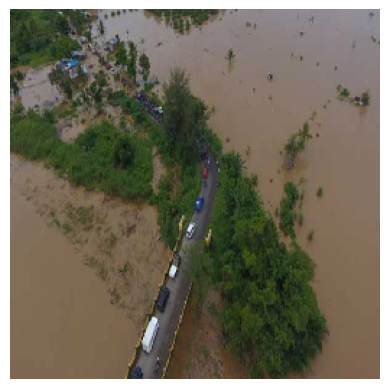

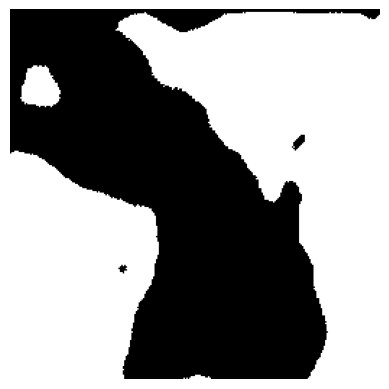

In [ ]:
i =6

subset = imgs[:10]


img = subset[i]

show_image(img)


pred = get_pred(model(subset),i)
show_mask(img,pred,alpha=1)
